In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks


In [2]:
def butter_lowpass_filter(data, cutoff=5, fs=100, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)


In [28]:
def process_curl(file_path, label):
    df = pd.read_csv(file_path)
    df.columns = ["Temps", "ax", "ay", "az"]

    # Filtrage
    df["ax_f"] = butter_lowpass_filter(df["ax"])
    df["ay_f"] = butter_lowpass_filter(df["ay"])
    df["az_f"] = butter_lowpass_filter(df["az"])

    # acc_mag
    df["acc_mag"] = np.sqrt(df["ax_f"]**2 + df["ay_f"]**2 + df["az_f"]**2)

    # Détection répétitions
    peaks, _ = find_peaks(df["acc_mag"], height=np.mean(df["acc_mag"]))
    df["rep"] = 0
    df.loc[peaks, "rep"] = 1
    df["rep"] = df["rep"].cumsum()

    # Vitesse instantanée
    df["speed"] = np.gradient(df["acc_mag"], df["Temps"])

    # Métriques globales
    amplitude = df["acc_mag"].max() - df["acc_mag"].min()
    stabilite = df["acc_mag"].std()
    vitesse_moy = abs(df["speed"]).mean()

    ascent = df["speed"][df["speed"] > 0].mean()
    descent = abs(df["speed"][df["speed"] < 0].mean())
    symetrie = 1 - abs(ascent - descent)/max(ascent, descent)

    # Métriques rep-par-rep
    amplitudes_rep = df.groupby("rep")["acc_mag"].max() - df.groupby("rep")["acc_mag"].min()
    amplitude_mean_rep = amplitudes_rep.mean()
    amplitude_std_rep = amplitudes_rep.std()

    # Export
    metrics = {
        "label": label,
        "reps": len(peaks),
        "amplitude": amplitude,
        "stabilite": stabilite,
        "vitesse_moy": vitesse_moy,
        "symetrie": symetrie,
        "amplitude_mean_rep": amplitude_mean_rep,
        "amplitude_std_rep": amplitude_std_rep,
        "rep_amplitudes_series": amplitudes_rep
    }

    return df, metrics, peaks

# Jerk = dérivée de l'accélération → mesure de propreté du mouvement
df_s["jerk"] = np.gradient(df_s["acc_mag"])
df_ns["jerk"] = np.gradient(df_ns["acc_mag"])

metrics_s["jerk_mean"] = df_s["jerk"].abs().mean()
metrics_ns["jerk_mean"] = df_ns["jerk"].abs().mean()



In [21]:
file_s = r"C:\Analyse de donnée\CWA-DATA nico bicep curl.csv"
file_ns = r"C:\Analyse de donnée\CWA-DATA Achraf bicep curl.csv"

df_s, metrics_s, peaks_s = process_curl(file_s, "Sportif")
df_ns, metrics_ns, peaks_ns = process_curl(file_ns, "Non-Sportif")


In [13]:
df_compare = pd.DataFrame([metrics_s, metrics_ns])
df_compare.set_index("label", inplace=True)

df_compare["amplitude_CV"] = df_compare["amplitude_std_rep"] / df_compare["amplitude_mean_rep"]
print(df_compare)


             reps  amplitude  stabilite  vitesse_moy  symetrie  \
label                                                            
Sportif       229   1.399371   0.082289     0.495739  0.982461   
Non-Sportif   130   1.208217   0.173973     0.998915  0.944830   

             amplitude_mean_rep  amplitude_std_rep  \
label                                                
Sportif                0.162951           0.168338   
Non-Sportif            0.375303           0.274777   

                                         rep_amplitudes_series  amplitude_CV  
label                                                                         
Sportif      rep
0      0.132676
1      0.288390
2      0.2...      1.033055  
Non-Sportif  rep
0      0.367127
1      0.679172
2      0.3...      0.732146  


In [24]:
# Ajout amplitude_CV dans les dictionnaires pour éviter KeyError
metrics_s["amplitude_CV"] = metrics_s["amplitude_std_rep"] / metrics_s["amplitude_mean_rep"]
metrics_ns["amplitude_CV"] = metrics_ns["amplitude_std_rep"] / metrics_ns["amplitude_mean_rep"]


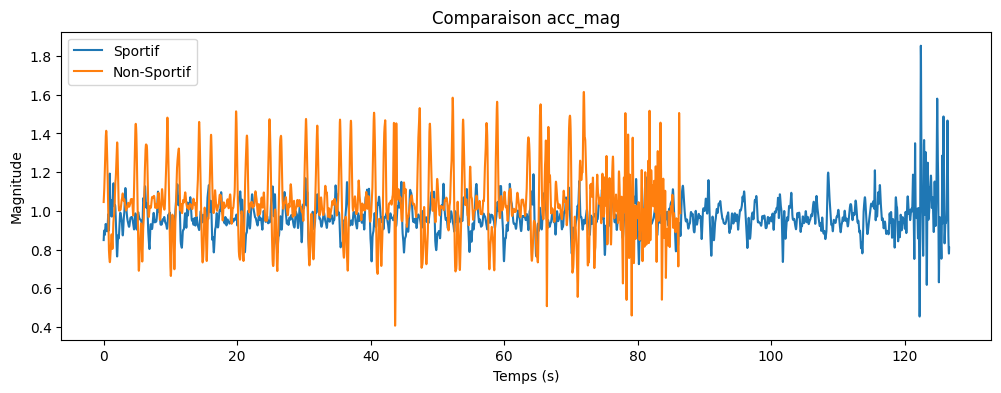

In [25]:
plt.figure(figsize=(12,4))
plt.plot(df_s["Temps"], df_s["acc_mag"], label="Sportif")
plt.plot(df_ns["Temps"], df_ns["acc_mag"], label="Non-Sportif")
plt.legend()
plt.title("Comparaison acc_mag")
plt.xlabel("Temps (s)")
plt.ylabel("Magnitude")
plt.show()


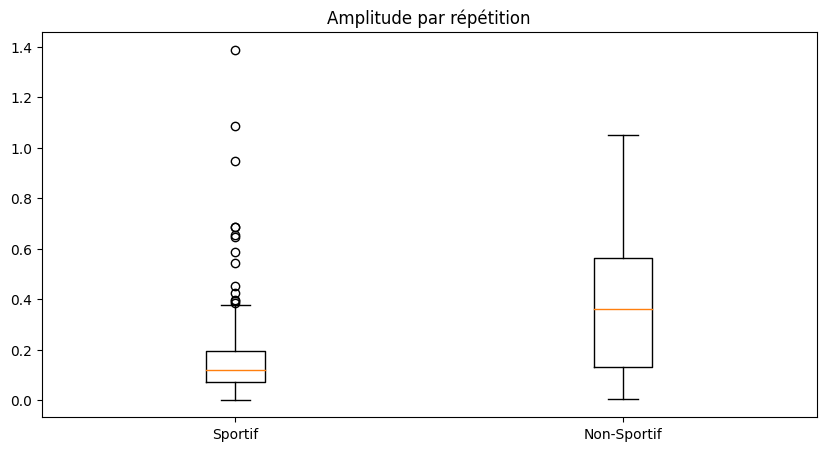

In [26]:
plt.figure(figsize=(10,5))
plt.boxplot([metrics_s["rep_amplitudes_series"], metrics_ns["rep_amplitudes_series"]],
            labels=["Sportif", "Non-Sportif"])
plt.title("Amplitude par répétition")
plt.show()


In [30]:
print("\n===== Résumé Sportif vs Non-Sportif =====")

if metrics_s["amplitude_CV"] < metrics_ns["amplitude_CV"]:
    print("✔ Le sportif a une amplitude plus régulière.")
else:
    print("✔ Le non-sportif est plus régulier en amplitude.")

if metrics_s["stabilite"] < metrics_ns["stabilite"]:
    print("✔ Le sportif a un geste plus stable.")
else:
    print("✔ Le non-sportif a un geste plus stable.")

if metrics_s["vitesse_moy"] < metrics_ns["vitesse_moy"]:
    print("✔ Le sportif contrôle mieux sa vitesse (moins d’à-coups).")
else:
    print("✔ Le non-sportif utilise une vitesse plus faible ou plus variable.")

if metrics_s["jerk_mean"] < metrics_ns["jerk_mean"]:
    print("✔ Le sportif a un mouvement techniquement plus propre (sans triche).")
else:
    print("✘ Le non-sportif a moins de jerk → mouvement plus propre.")
    
print(f"Jerk moyen Sportif : {metrics_s['jerk_mean']:.4f}")
print(f"Jerk moyen Non-sportif : {metrics_ns['jerk_mean']:.4f}")




===== Résumé Sportif vs Non-Sportif =====
✔ Le non-sportif est plus régulier en amplitude.
✔ Le sportif a un geste plus stable.
✔ Le sportif contrôle mieux sa vitesse (moins d’à-coups).
✔ Le sportif a un mouvement techniquement plus propre (sans triche).
Jerk moyen Sportif : 0.0050
Jerk moyen Non-sportif : 0.0101
